<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Define-a-pytorch-Dataset-object-to-contain-the-training-and-testing-data" data-toc-modified-id="Define-a-pytorch-Dataset-object-to-contain-the-training-and-testing-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Define a pytorch Dataset object to contain the training and testing data</a></span></li><li><span><a href="#Define-training-methods-for-the-model" data-toc-modified-id="Define-training-methods-for-the-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define training methods for the model</a></span></li><li><span><a href="#Define-testing-methods-for-the-model" data-toc-modified-id="Define-testing-methods-for-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define testing methods for the model</a></span></li><li><span><a href="#Define-plotting-method-for-loss" data-toc-modified-id="Define-plotting-method-for-loss-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define plotting method for loss</a></span></li><li><span><a href="#Define-Model-Architecture" data-toc-modified-id="Define-Model-Architecture-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Define Model Architecture</a></span></li><li><span><a href="#Define-Run-function" data-toc-modified-id="Define-Run-function-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Define Run function</a></span></li><li><span><a href="#Create-Datasets-for-Each-Gait-File" data-toc-modified-id="Create-Datasets-for-Each-Gait-File-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Create Datasets for Each Gait File</a></span></li><li><span><a href="#Run-and-plot-results" data-toc-modified-id="Run-and-plot-results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Run and plot results</a></span></li></ul></div>

In [2]:
import sys
import numpy as np
from matplotlib import pyplot
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

# from icecream import ic
import pandas as pd
from math import sqrt, inf
import glob
import csv

from pathlib import Path



import random



# print("USING pytorch VERSION: ", torch.__version__)

## Define Constants and Hyperparams

In [3]:
ANIMATIONS_PATH = Path("Animations/")
DATA_PATH = Path("Data/")
SANITY_PATH = Path("Sanity_Checks/")
MODEL_OUTPUT_PATH = Path("Model_Outputs/")
MODEL_PATH = Path("Models/")
CSV_HEADER = [
                "FL A1 DF 1",
                "FL A1 DF 2",
                "FL A2 DF 1",
                "FL A2 DF 2",
                "FL A3 DF 1",
                "FL A3 DF 2",
                "FR A1 DF 1",
                "FR A1 DF 2",
                "FR A2 DF 1",
                "FR A2 DF 2",
                "FR A3 DF 1",
                "FR A3 DF 2",
                "BL A1 DF 1",
                "BL A1 DF 2",
                "BL A2 DF 1",
                "BL A2 DF 2",
                "BL A3 DF 1",
                "BL A3 DF 2",
                "BR A1 DF 1",
                "BR A1 DF 2",
                "BR A2 DF 1",
                "BR A2 DF 2",
                "BR A3 DF 1",
                "BR A3 DF 2",
                "SP A1 DF 1",
                "SP A1 DF 2",
                "SP A2 DF 1",
                "SP A2 DF 2",
            ]

epochs = 5

        

## Define a pytorch Dataset object to contain the training and testing data
Pytorch handles data shuffling and batch loading, as long as the user provides a "Dataset" class. This class is just a wrapper for your data that casts the data into pytorch tensor format and returns slices of the data. In this case, our data is in numpy format, which conveniently pytorch has a method for converting to their native format.

The init function takes the path to the csv and creates a dataset out of it. I actually have three different options here. The dataset could be composed such that x is the 'timestamp' of the movement,the previous set of angles, or a tuple of both.

In [4]:
class AngleDataset(Dataset):
    def __init__(self, x, y):
        x_dtype = torch.FloatTensor
        y_dtype = torch.FloatTensor  # for MSE or L1 Loss

        self.length = x.shape[0]

        self.x_data = torch.from_numpy(x).type(x_dtype)
        self.y_data = torch.from_numpy(y).type(y_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length


def create_datasets(csv_path: str, train_perc: float = 0.8, nosplit=False):
    df = pd.read_csv(csv_path)
    length = len(df)
    time = 10
    timestep = 0.005

    # x_data = np.array([])
    # y_data = np.array([])
    x_data = []
    y_data = []

    sin_test_timepoints = (
        np.random.rand(length, 1) * time
    )  # Repeat data generation for test set
    sin_test_timepoints = sin_test_timepoints.ravel()
    sin_iter = iter(sin_test_timepoints)

    # data order = sin, angles, torso, touch_sens

    # if x = curr angles and y = next angles
    for i in range(len(df)):

        x = []
        y = []

        if i < length - 1:
            x = np.append(x, df.iloc[i])
            y = np.append(y, df.iloc[i + 1][:-4])  # only include angles
        else:
            # since it loops anyway
            x = np.append(x, df.iloc[i])
            y = np.append(y, df.iloc[0][:-4])

        x = np.append([next(sin_iter)], x)

        x_data.append(x)
        y_data.append(y)

    x_data = np.array(x_data, dtype=np.float64)
    y_data = np.array(y_data, dtype=np.float64)

    if not nosplit:

        last_train_idx = int(len(x_data) * train_perc)

        train_x = x_data[:last_train_idx]
        train_y = y_data[:last_train_idx]
        test_x = x_data[last_train_idx:]
        test_y = y_data[last_train_idx:]

        return AngleDataset(x=train_x, y=train_y), AngleDataset(x=test_x, y=test_y)
    else:
        return AngleDataset(x=x_data, y=y_data)

In [5]:
# get averages for each csv

def get_avg_range(df_col):
    return (df_col.min() + df_col.max()) / 2

def get_avgs(fp: str):

    df = pd.read_csv(fp)

    return df.apply(get_avg_range, axis=0).tolist() #0 axis is cols, 1 is rows

avgs = {}


for file in DATA_PATH.glob("*_kinematic.csv"):
    avgs[file.stem.split("_")[0]] = get_avgs(file)

avgs.keys()


dict_keys(['canter', 'gallop', 'trot', 'walk'])

## Define training methods for the model
These methods use an initialized model and training data to iteratively perform the forward and backward pass of optimization. Aside from some data reformatting that depends on the input, output, and loss function, these methods will always be the same for any shallow neural network.

In [6]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)

    # Compute loss.
    loss = loss_fn(y_predict, y)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

    

    return loss.data.item()


def train(model, loader, optimizer, loss_fn, epochs=5):
    losses = list()

    batch_index = 0
    for e in range(epochs):
        for x, y in loader:
            loss = train_batch(
                model=model, x=x, y=y, optimizer=optimizer, loss_fn=loss_fn
            )
            losses.append(loss)

            batch_index += 1

        if e % 50 == 0:
            pass
        #   ic("Epoch: ", e+1)
        #   ic("Batches: ", batch_index)

    return losses

## Define testing methods for the model
These methods are like training, but we don't need to update the parameters of the model anymore because when we call the test() method, the model has already been trained. Instead, this method just calculates the predicted y values and returns them, AKA the forward pass.


In [7]:
def test_batch(model, x, y):
    # run forward calculation
    y_predict = model.forward(x)

    return y, y_predict


def test(model, loader):
    y_vectors = list()
    y_predict_vectors = list()

    batch_index = 0
    for x, y in loader:
        y, y_predict = test_batch(model=model, x=x, y=y)

        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())

        batch_index += 1

    y_predict_vector = np.concatenate(y_predict_vectors)

    return y_predict_vector

## Define plotting method for loss
This is a plotting method for looking at the behavior of the loss over training iterations.

In [8]:
def plot_loss(losses, title: str, show=True):
    fig = pyplot.gcf()
    fig.set_size_inches(8, 6)
    ax = pyplot.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    pyplot.title(title)

    pyplot.plot(x_loss, losses)

    if show:
        pyplot.show()

    pyplot.close()

## Define Model Architecture
- 33 inputs = 3 joint angles per leg, 4 legs, 2 DOF per joint. 4 touch sensors. 1 sine timestamp.
- 28 outputs = *same as above, except just the joint angles*


In [13]:
class GaitModel(nn.Module):
    def __init__(self, layer_sizes, avgs_key, batch_norm=True, dropout=0):
        super(GaitModel, self).__init__()
        self.avgs = torch.FloatTensor(avgs[avgs_key])
        hidden_layers = []

        for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes):
            layers = [nn.Linear(nlminus1, nl), nn.ReLU()]
            if batch_norm:
                layers.append(nn.BatchNorm1d(nl))
            
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            

            hidden_layers.append(nn.Sequential(*layers))


        # The output layer does not include an activation function.
        # See: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1])

        # tanh = torch.nn.Tanh()

        # Group all layers into the sequential container
        all_layers = hidden_layers + [output_layer]
        self.layers = nn.Sequential(*all_layers)

    def forward(self, X):
        tmp = np.zeros(X.shape)
        tmp[:, 0] = X[:, 0]
        X2 = X[:, 1:]
        X2 -= self.avgs

        tmp[:, 1:] = X2[:, :]
        X = torch.FloatTensor(tmp)

        return self.layers(X)

## Define Run function

In [14]:
def run(train_dataset, test_dataset, avgs_key, epochs=4, layer_sizes=[33, 31, 30, 28], batch_norm=True, dropout=0):
    # Batch size is the number of training examples used to calculate each iteration's gradient
    batch_size_train = 33

    data_loader_train = DataLoader(
        dataset=train_dataset, batch_size=batch_size_train, shuffle=True
    )
    data_loader_test = DataLoader(
        dataset=test_dataset, batch_size=len(test_dataset), shuffle=False
    )

    # Define the hyperparameters
    learning_rate = 1e-3

    pytorch_model = GaitModel(layer_sizes, avgs_key, batch_norm, dropout)

    # Initialize the optimizer with above parameters
    optimizer = optim.Adam(pytorch_model.parameters(), lr=learning_rate)

    # Define the loss function
    loss_fn = nn.MSELoss()  # mean squared error

    # Train and get the resulting loss per iteration
    loss = train(
        model=pytorch_model,
        loader=data_loader_train,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=epochs,
    )

    # Test and get the resulting predicted y values
    y_predict = test(model=pytorch_model, loader=data_loader_test)

    return loss, y_predict, pytorch_model

## Create Datasets for Each Gait File

In [18]:
angles_path = Path("Data")
names_and_ds = []

for filename in angles_path.glob("*_kinematic.csv"):

    gait_name = filename.stem.split("_")[0]
    train_ds, test_ds = create_datasets(filename)
    names_and_ds.append((gait_name, train_ds, test_ds))

print(names_and_ds)

[('canter', <__main__.AngleDataset object at 0x00000197961E47C8>, <__main__.AngleDataset object at 0x0000019795F68F08>), ('gallop', <__main__.AngleDataset object at 0x00000197911631C8>, <__main__.AngleDataset object at 0x00000197961E4208>), ('trot', <__main__.AngleDataset object at 0x00000197960247C8>, <__main__.AngleDataset object at 0x00000197961A1BC8>), ('walk', <__main__.AngleDataset object at 0x000001979118E648>, <__main__.AngleDataset object at 0x000001979118E748>)]


## Run and plot results

canter
Final loss for canter: 0.007411548914387822


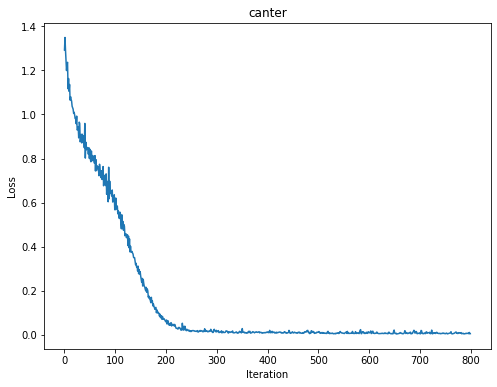

gallop
Final loss for gallop: 0.00897720744367689


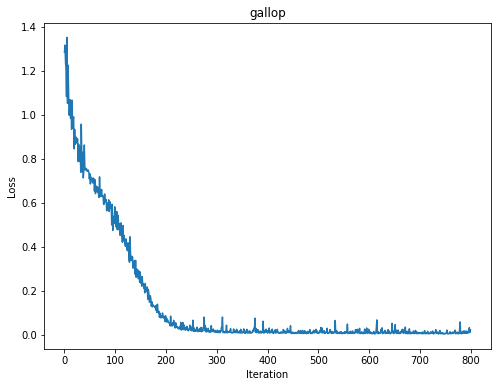

trot
Final loss for trot: 0.004307158536976203


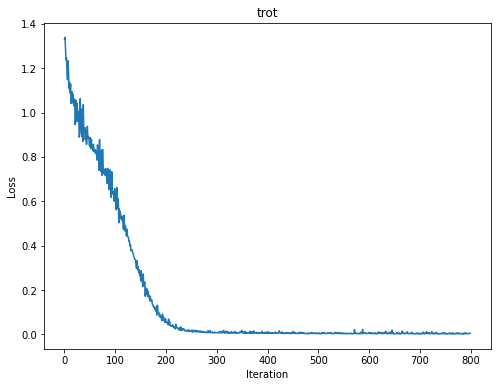

walk
Final loss for walk: 0.005080042432527989


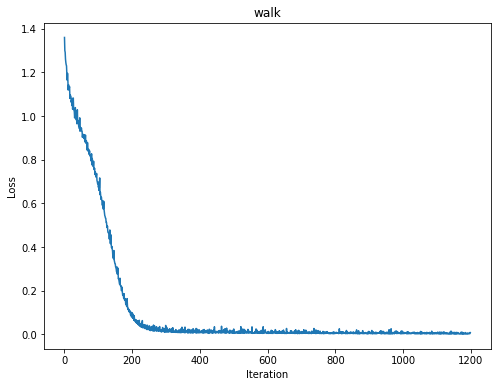

0.006443989331892225

In [19]:
def train_csv_plot(names_and_ds, model_path=MODEL_PATH, csv_path=DATA_PATH, plot=True, dropout=0, batch_norm=True, extra_id: str = ""):

    final_losses = []

    for name, train_ds, test_ds in names_and_ds:
        print(name)

        train_ds.x_data.shape

        losses, y_predict, model_to_save = run(
            train_dataset=train_ds, test_dataset=test_ds, avgs_key=name, epochs=400, dropout=dropout, batch_norm=batch_norm
        )


        # new /
        all_ds = create_datasets(DATA_PATH / f'{name}_kinematic.csv', nosplit=True)


        data_loader_all = DataLoader(
            dataset=all_ds, batch_size=33, shuffle=False
        )
        y_predict = test(model_to_save, data_loader_all)

        spacer = "_" if extra_id != "" else ""

        # / new
        # Save the outputs to a csv for quicker comparisons later
        with open(csv_path / f'{name}_model{spacer}{extra_id}.csv', "w", newline="") as f:
            writer = csv.writer(
                f,
                quoting=csv.QUOTE_NONE,
            )

            writer.writerow(CSV_HEADER)
            for row in y_predict:
                writer.writerow(row)

        torch.save(model_to_save, model_path / f"{name}_model{spacer}{extra_id}.pt")

        final_loss = sum(losses[-100:])/100
        final_losses.append(final_loss)

        print(f"Final loss for {name}: {final_loss}")
        if plot:
            plot_loss(losses, name)

    return sum(final_losses)/len(final_losses)

        

train_csv_plot(names_and_ds)

## Sanity Check Data By Plotting
Also saving to files under Sanity_Checks

In [20]:

data_files = sorted([x for x in DATA_PATH.glob("*_kinematic.csv") if x.is_file()])
model_outputs = sorted([x for x in DATA_PATH.glob("*_model.csv") if x.is_file()])


In [21]:

for actual, pred in zip(data_files, model_outputs):
    
    dfa = pd.read_csv(actual)
    dfp = pd.read_csv(pred)


    plot_actual = dfa.plot(subplots=True, layout=(6, 6), figsize=(16, 16), title=f"{actual.stem}: actual")
    plot_predicted = dfp.plot(subplots=True, layout=(6, 6), figsize=(16, 16), title=f"{pred.stem}: predicted by model")

    

    plot_actual[0][0].get_figure().savefig( SANITY_PATH / f'{actual.stem}_actual.png', facecolor='white')
    plot_predicted[0][0].get_figure().savefig( SANITY_PATH / f'{pred.stem}_predicted.png', facecolor='white')
    



F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDepreca

Error in callback <function flush_figures at 0x0000019792847D38> (for post_execute):


KeyboardInterrupt: 

In [22]:
def plot_comparisons(data_files, model_outputs, save_path, extra_id:str = None):

    for actual, pred in zip(data_files, model_outputs):

        dfa = pd.read_csv(actual)
        dfp = pd.read_csv(pred)

        name = actual.stem.split("_")[0]

        fig, axs = pyplot.subplots(nrows=6, ncols=10, sharey=True, sharex=True, figsize=(16,12))
        fig.suptitle(f"{name}: actual (left) vs predicted (right)", fontsize=16)
        # fig.set_size_inches(9, 9, forward=True)
        for ax_arr in axs:
            for ax in ax_arr:
                # ax.set_aspect('equal')
                # ax.set_adjustable('box')
                ax.set_box_aspect(1)
        pyplot.subplots_adjust(left  = 0.025,
                right = 1.0,
                bottom = 0.1,
                top = 0.9,
                wspace = 0.5,
                hspace = 0.5)
        pyplot.ylim(-3, 3)
        fig.tight_layout()
        

        dfa = dfa.iloc[:, :-4]

        dfa_p1 = dfa.iloc[:, :6]
        dfa_p2 = dfa.iloc[:, 6:12]
        dfa_p3 = dfa.iloc[:, 12:18]
        dfa_p4 = dfa.iloc[:, 18:24]
        dfa_p5 = dfa.iloc[:, 24:]

        dfp_p1 = dfp.iloc[:, :6]
        dfp_p2 = dfp.iloc[:, 6:12]
        dfp_p3 = dfp.iloc[:, 12:18]
        dfp_p4 = dfp.iloc[:, 18:24]
        dfp_p5 = dfp.iloc[:, 24:]

        dfa_p1.plot(ax=axs[:,0], subplots=True)
        dfp_p1.plot(ax=axs[:,1], subplots=True)
        dfa_p2.plot(ax=axs[:,2], subplots=True)
        dfp_p2.plot(ax=axs[:,3], subplots=True)
        dfa_p3.plot(ax=axs[:,4], subplots=True)
        dfp_p3.plot(ax=axs[:,5], subplots=True)
        dfa_p4.plot(ax=axs[:,6], subplots=True)
        dfp_p4.plot(ax=axs[:,7], subplots=True)
        dfa_p5.plot(ax=axs[:-2,8], subplots=True)
        dfp_p5.plot(ax=axs[:-2,9], subplots=True)

        spacer = "_" if extra_id else ""
        
        fig.savefig( save_path / f"{name}_comparison{spacer}{extra_id}", facecolor="white")
    
        
# plot_comparisons(data_files, model_outputs, SANITY_PATH)


canter
Final loss for canter: 0.0034095451957546173
gallop
Final loss for gallop: 0.0029076447058469057
trot
Final loss for trot: 0.0014174100395757704
walk
Final loss for walk: 0.0011752053361851723


F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDepreca

canter
Final loss for canter: 0.09548080414533615
gallop
Final loss for gallop: 0.09050025478005409
trot
Final loss for trot: 0.06418629840016365
walk
Final loss for walk: 0.05611849406734109


F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDepreca

canter
Final loss for canter: 0.10418375976383686
gallop
Final loss for gallop: 0.10402088209986687
trot
Final loss for trot: 0.07996224891394377
walk
Final loss for walk: 0.0681929436698556


F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDepreca

canter
Final loss for canter: 0.007434674049727618
gallop
Final loss for gallop: 0.01117047674022615
trot
Final loss for trot: 0.004705869111930951
walk
Final loss for walk: 0.004816481425659731


F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
F:\Anaconda\envs\datascience\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDepreca

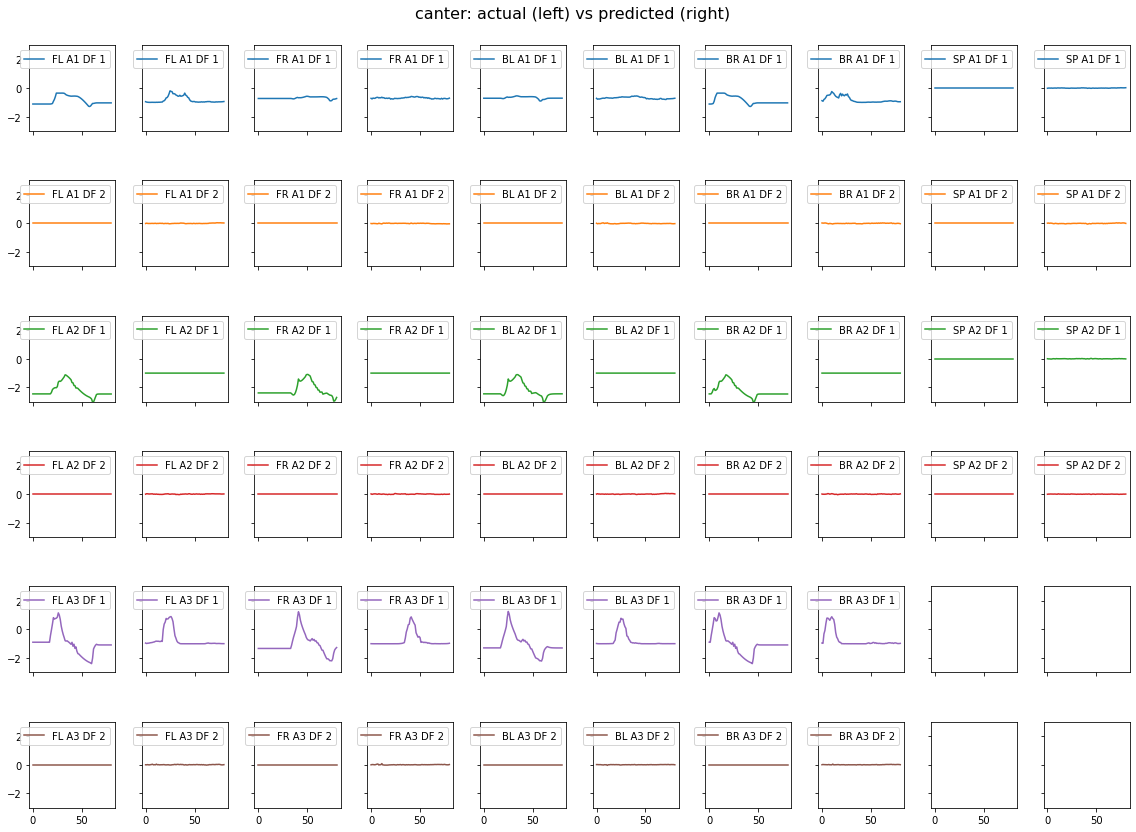

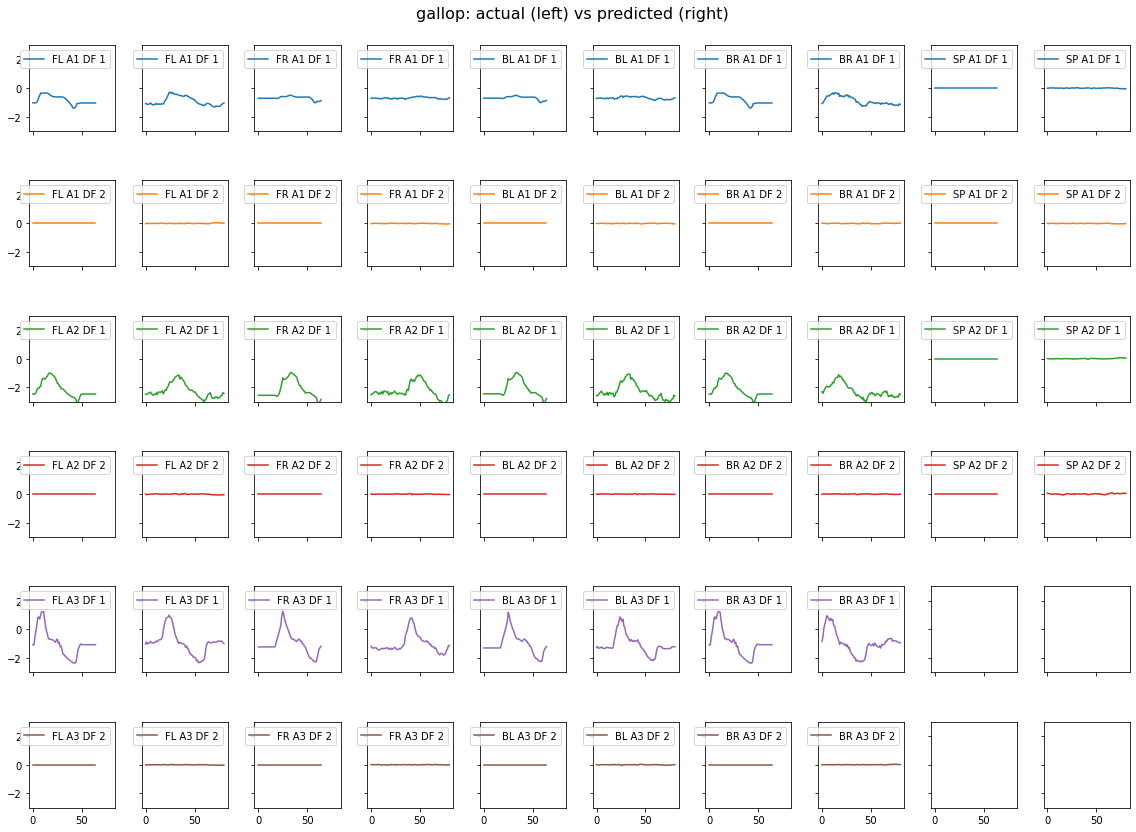

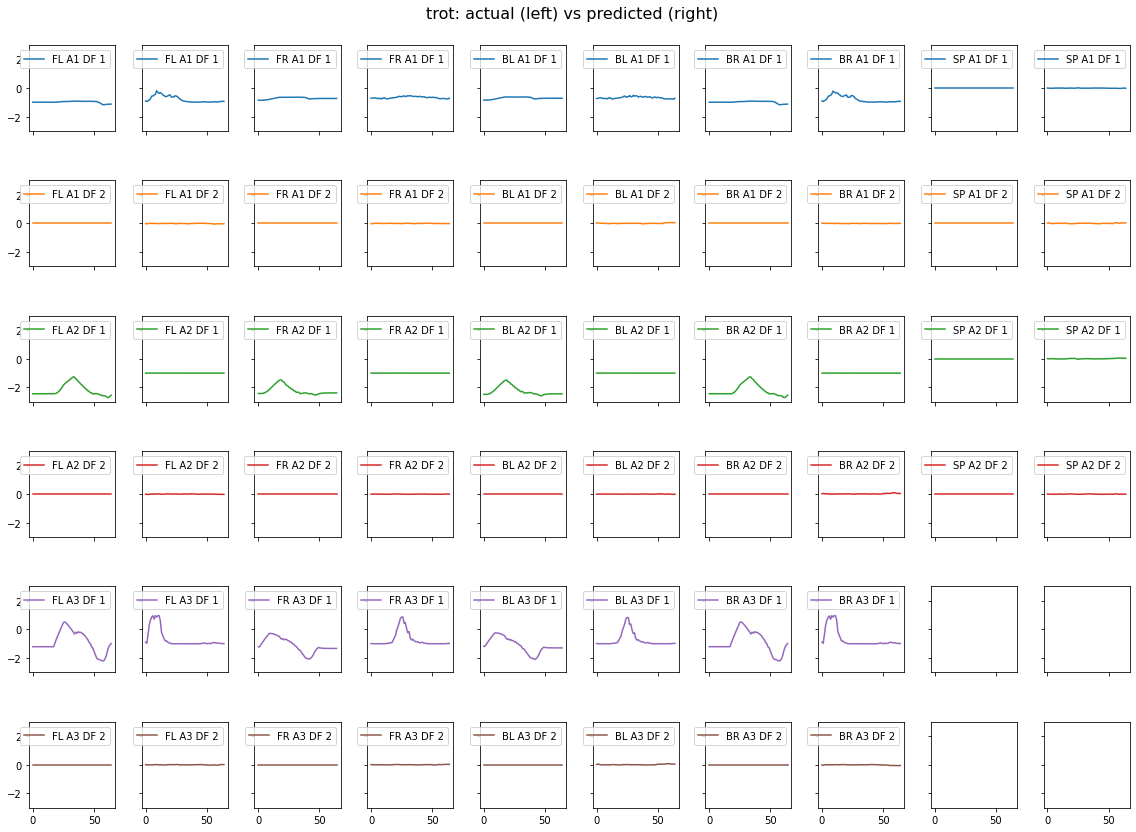

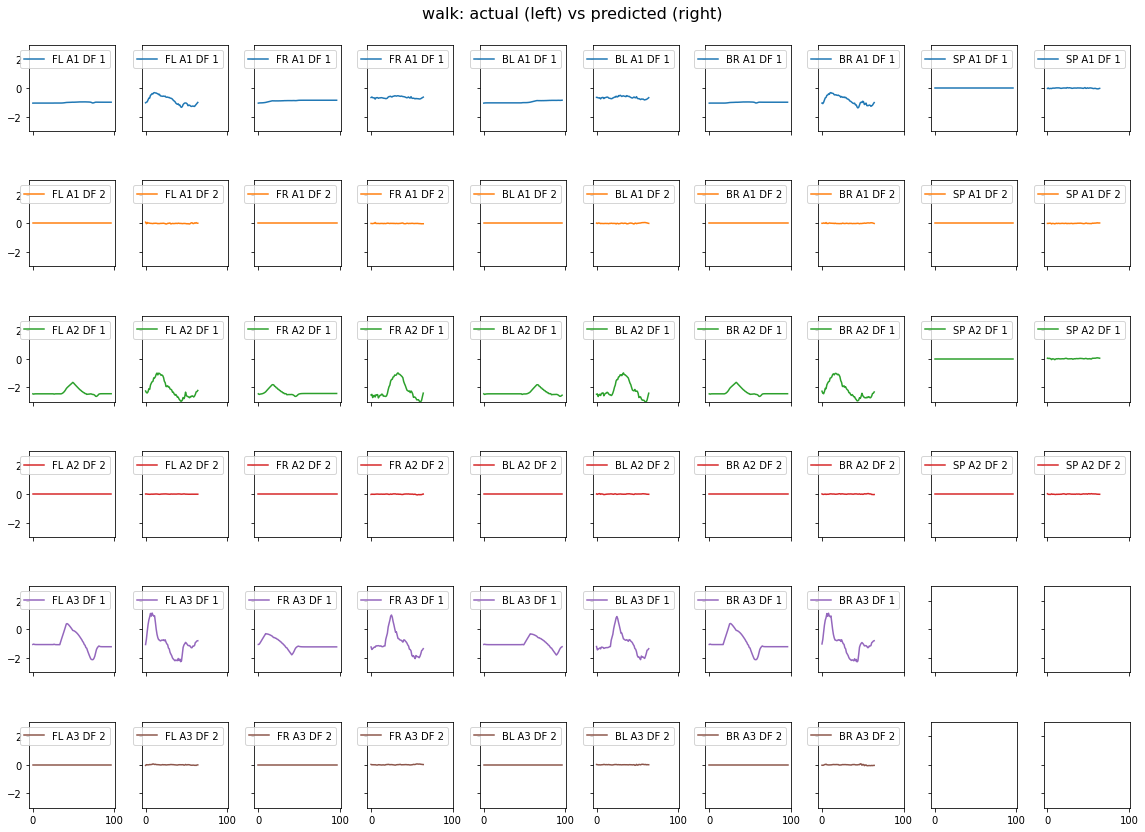

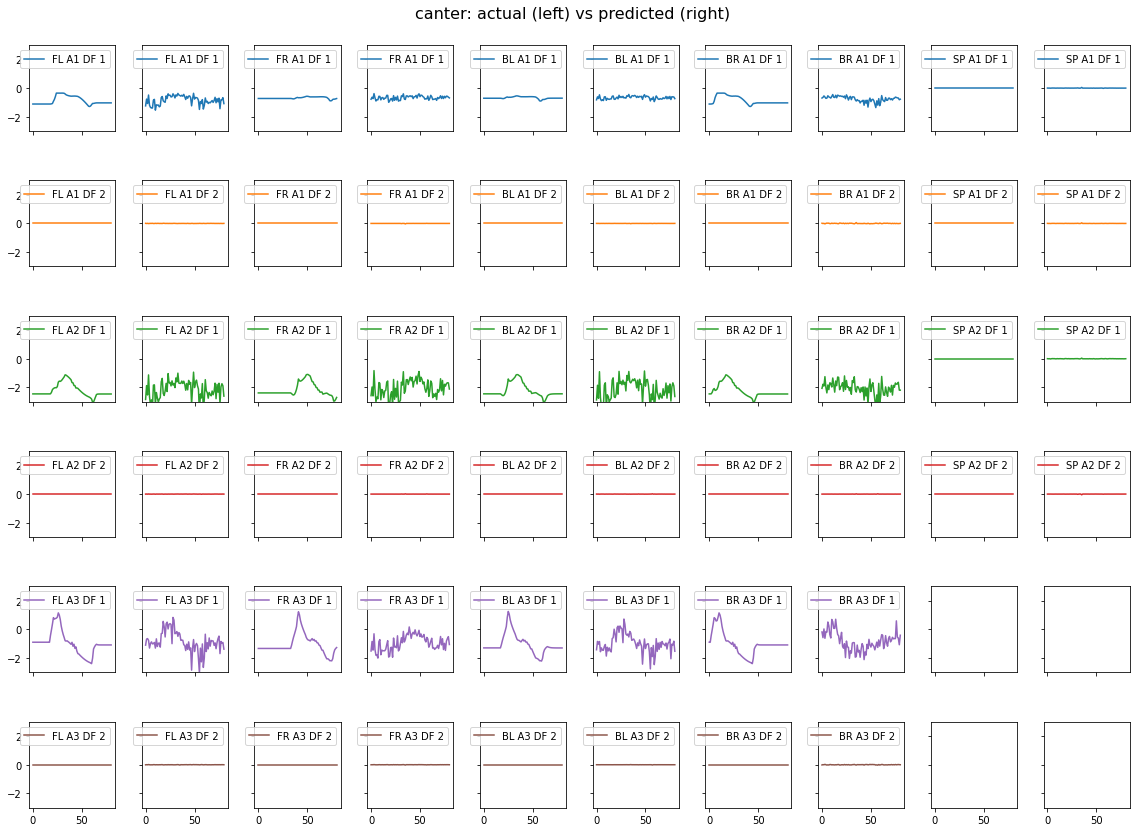

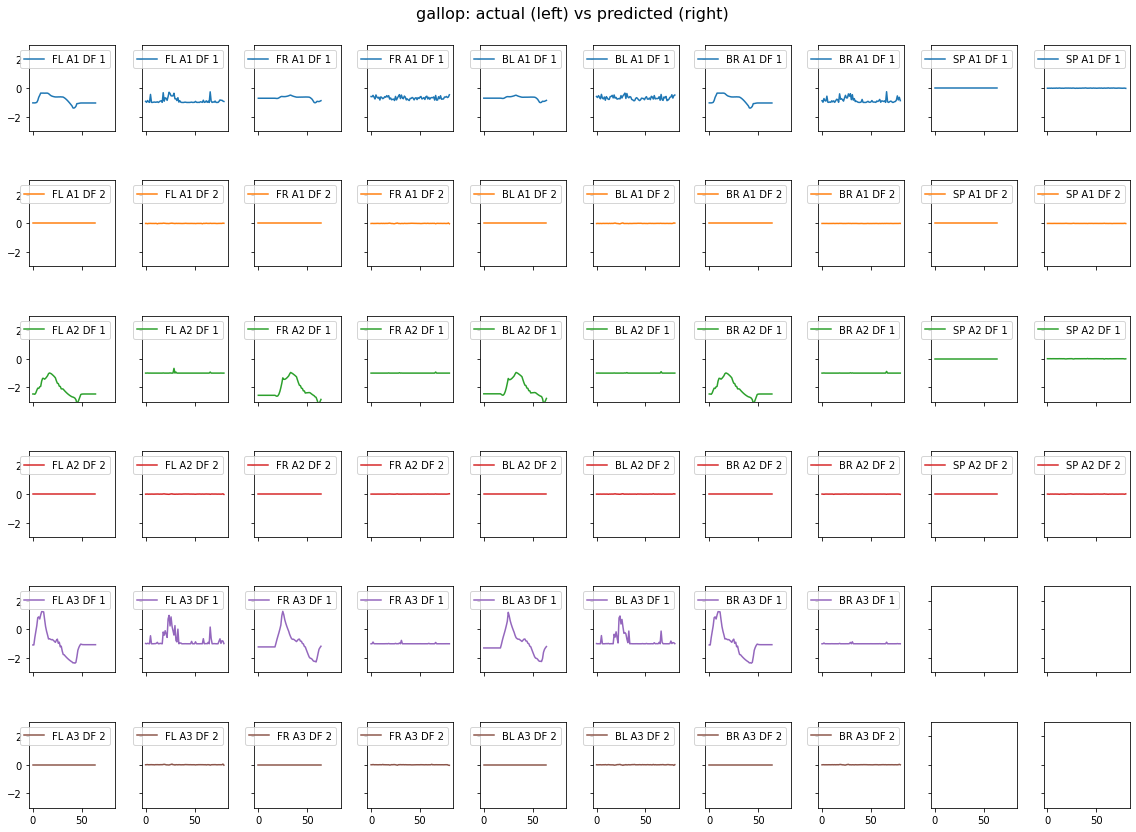

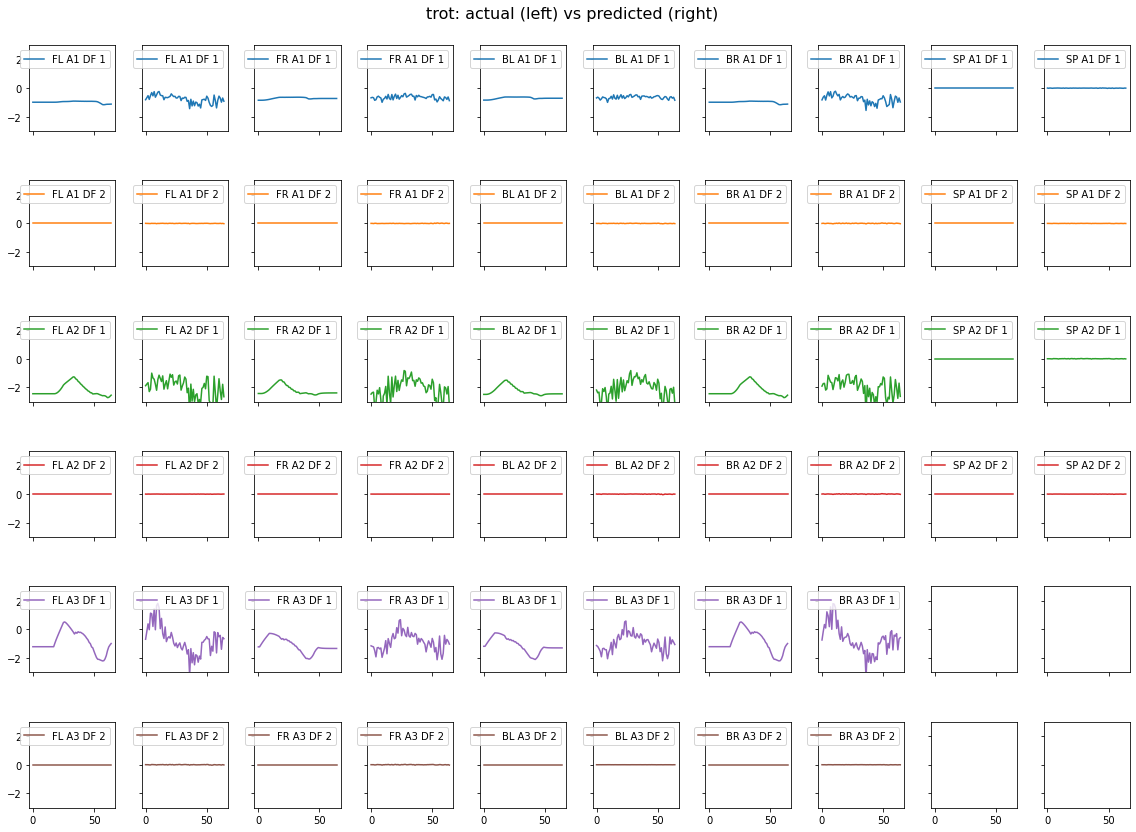

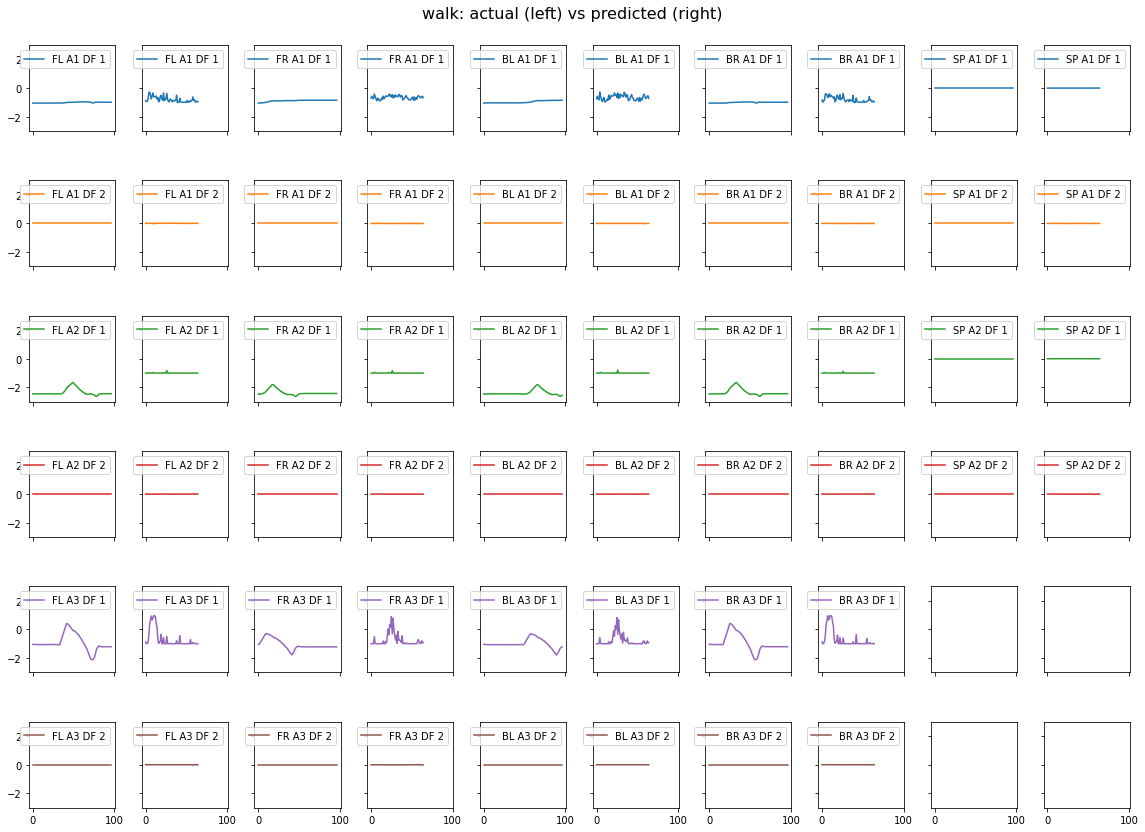

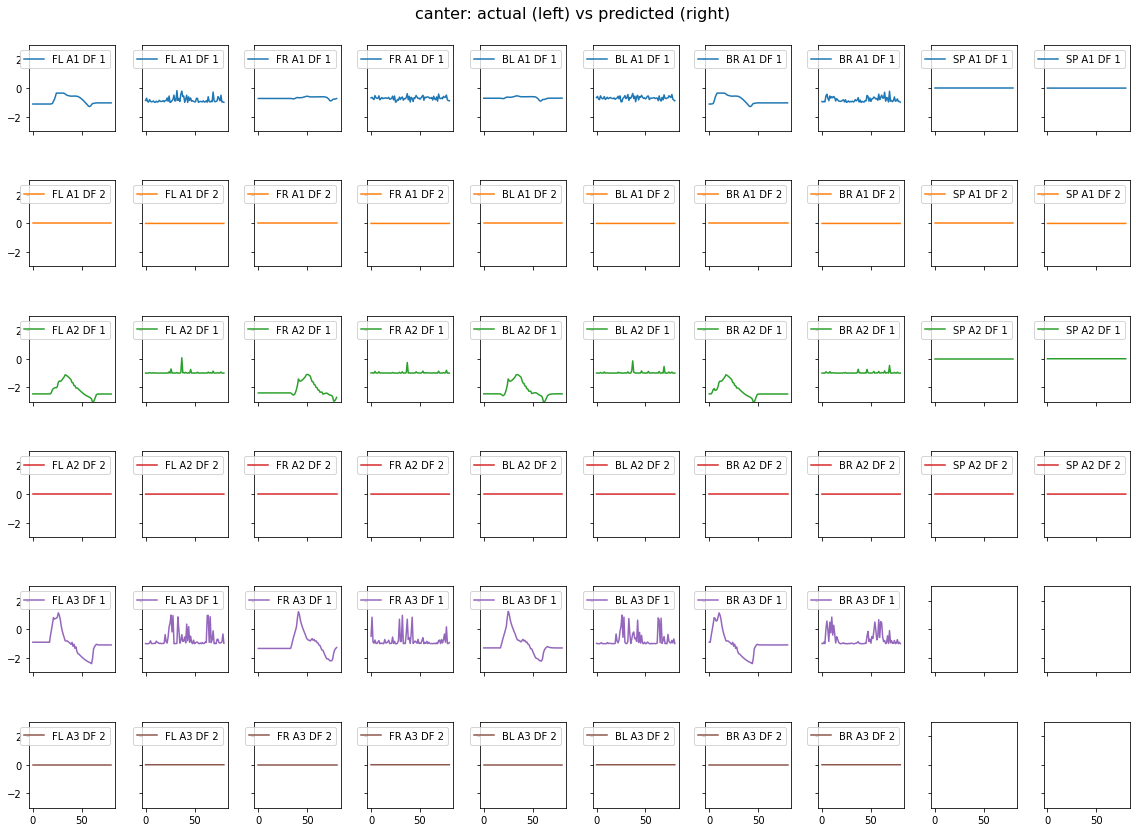

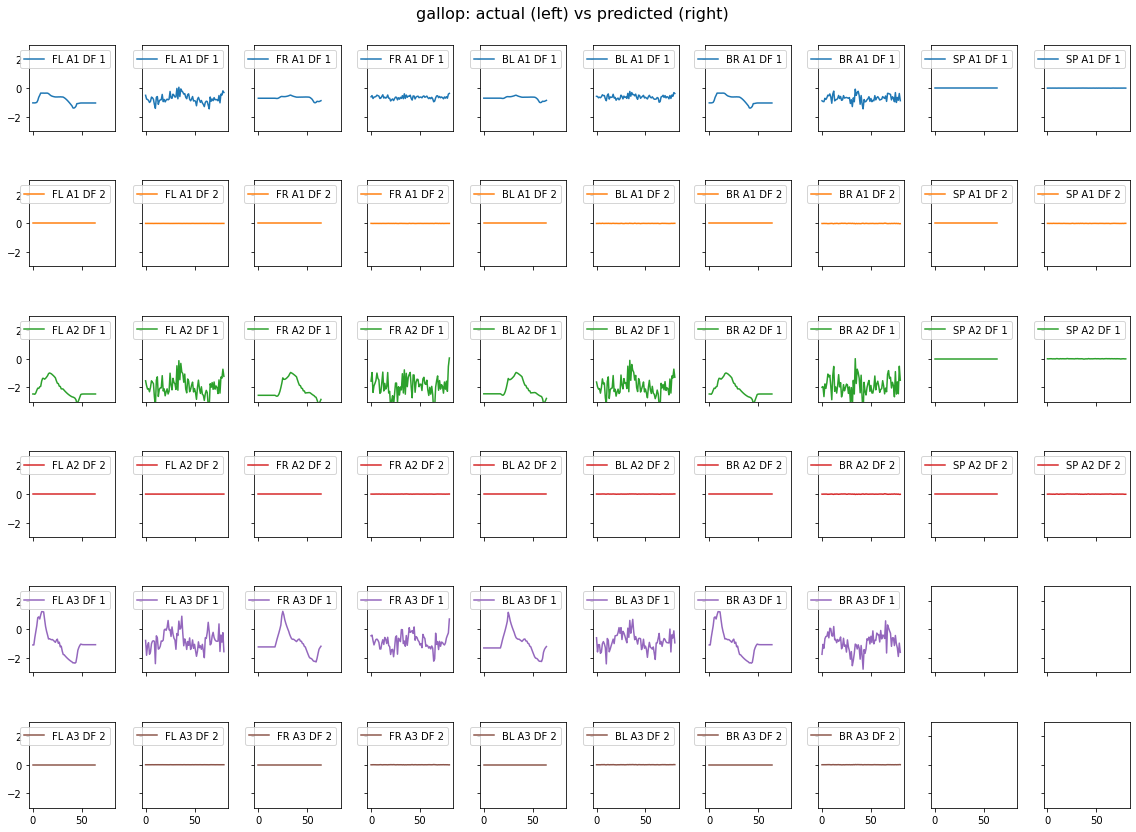

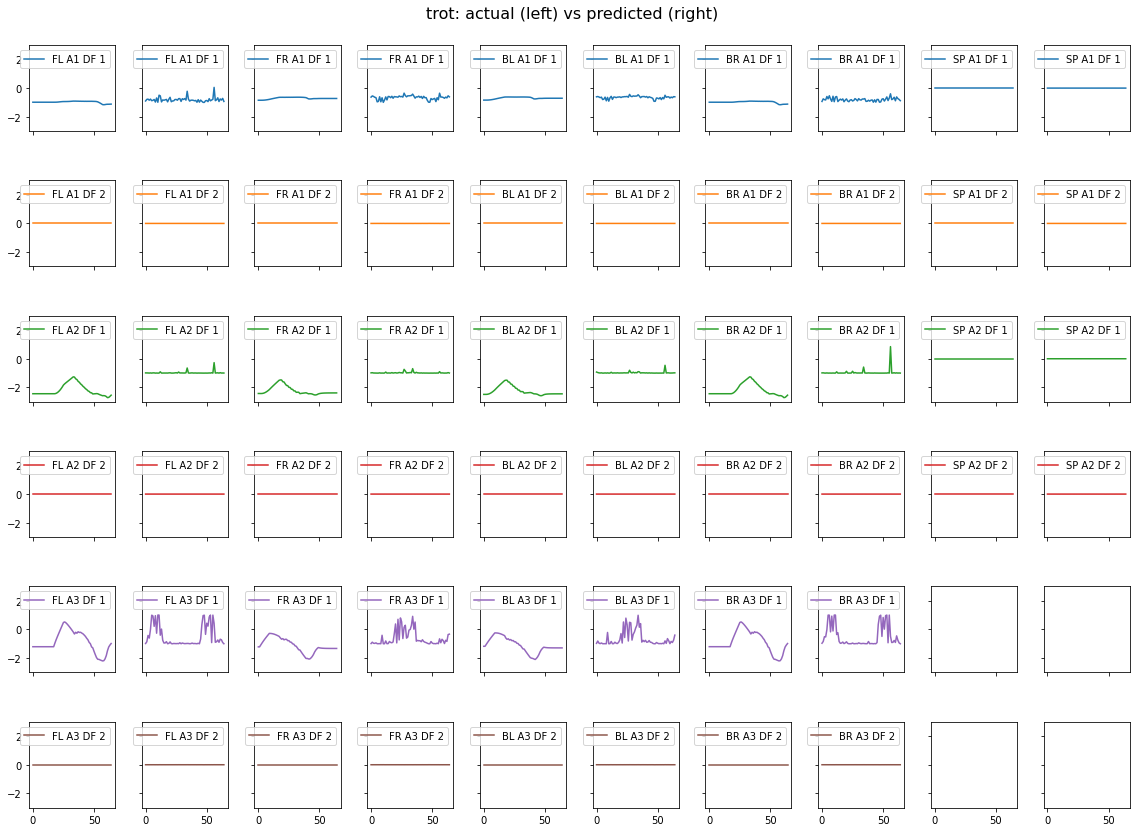

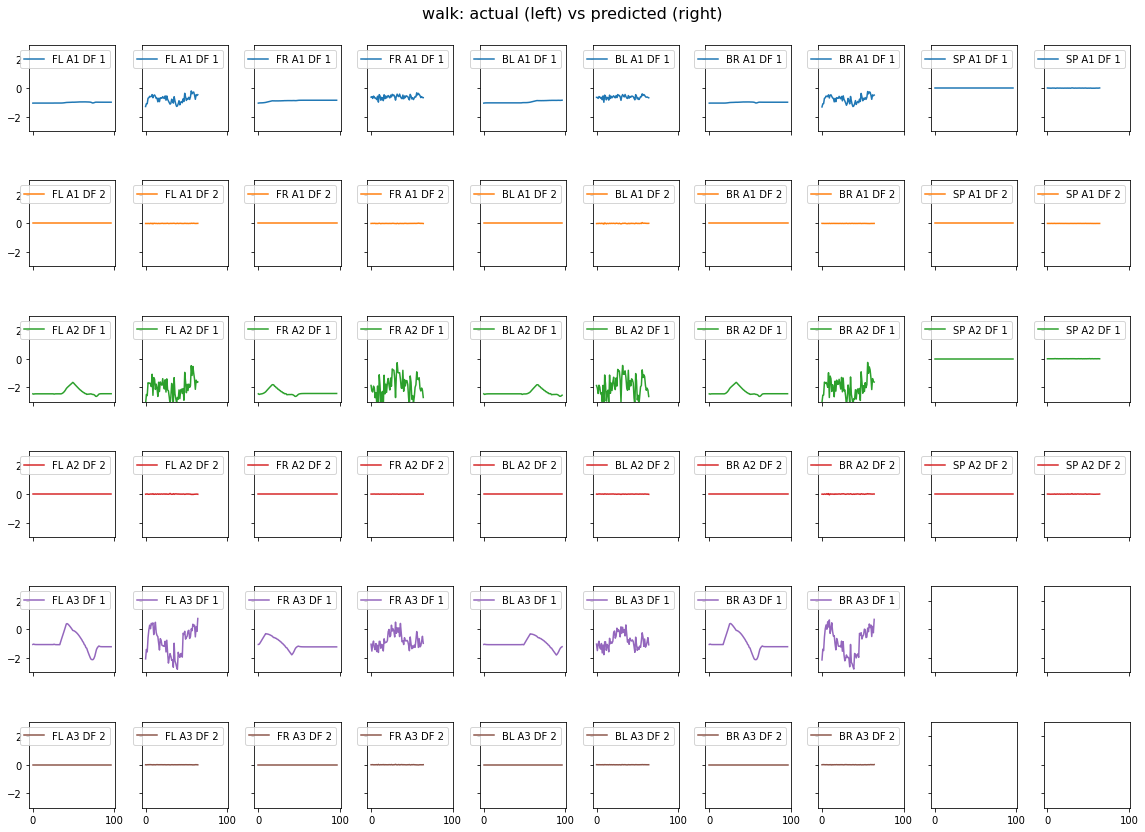

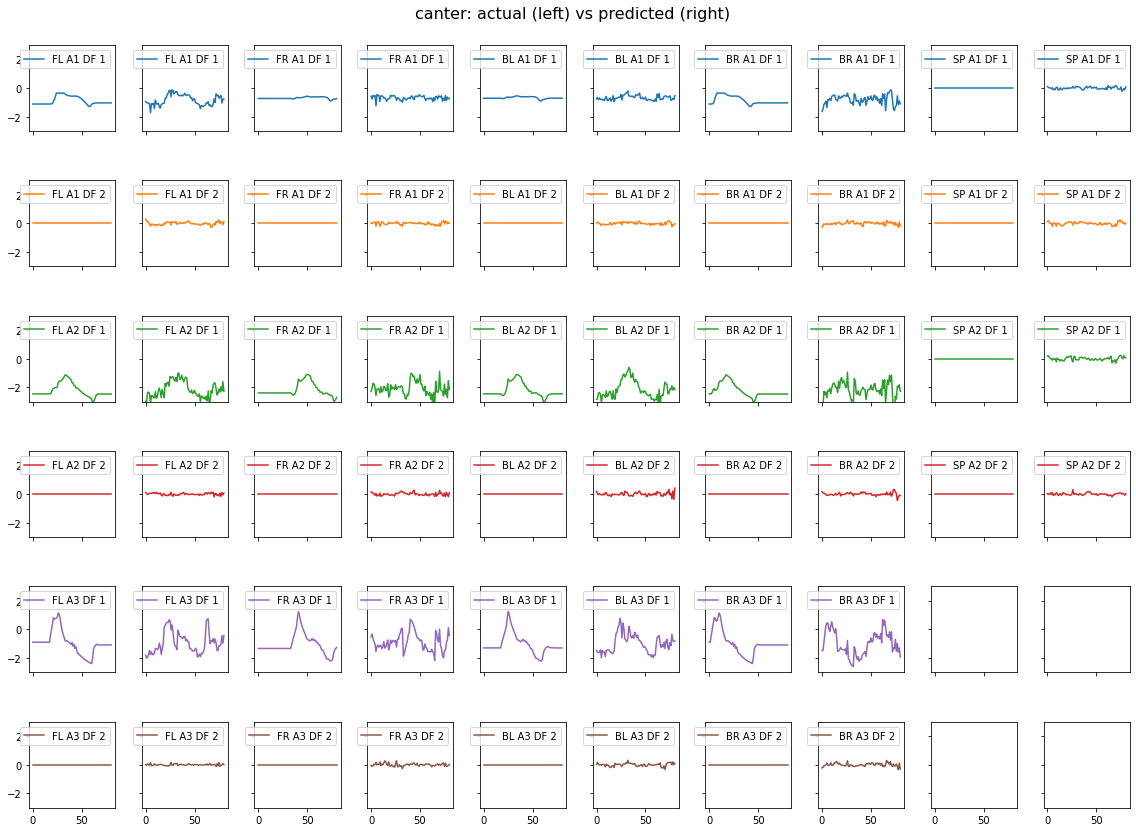

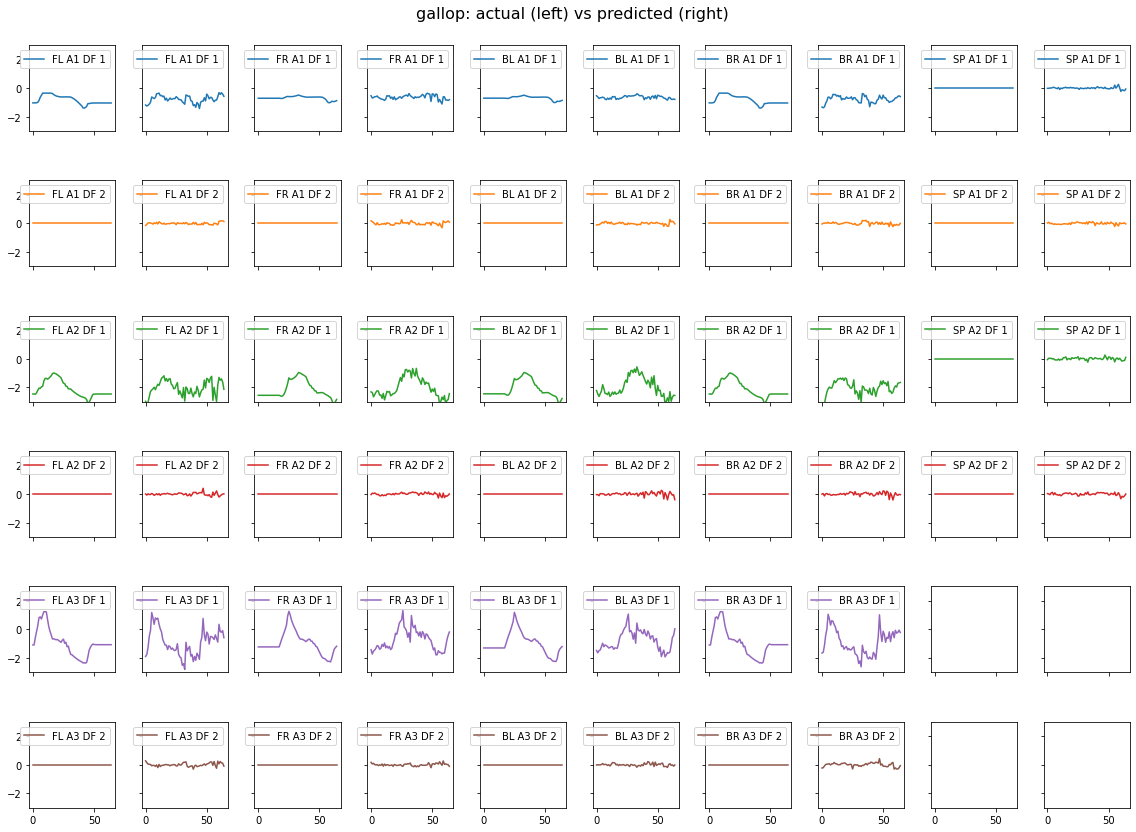

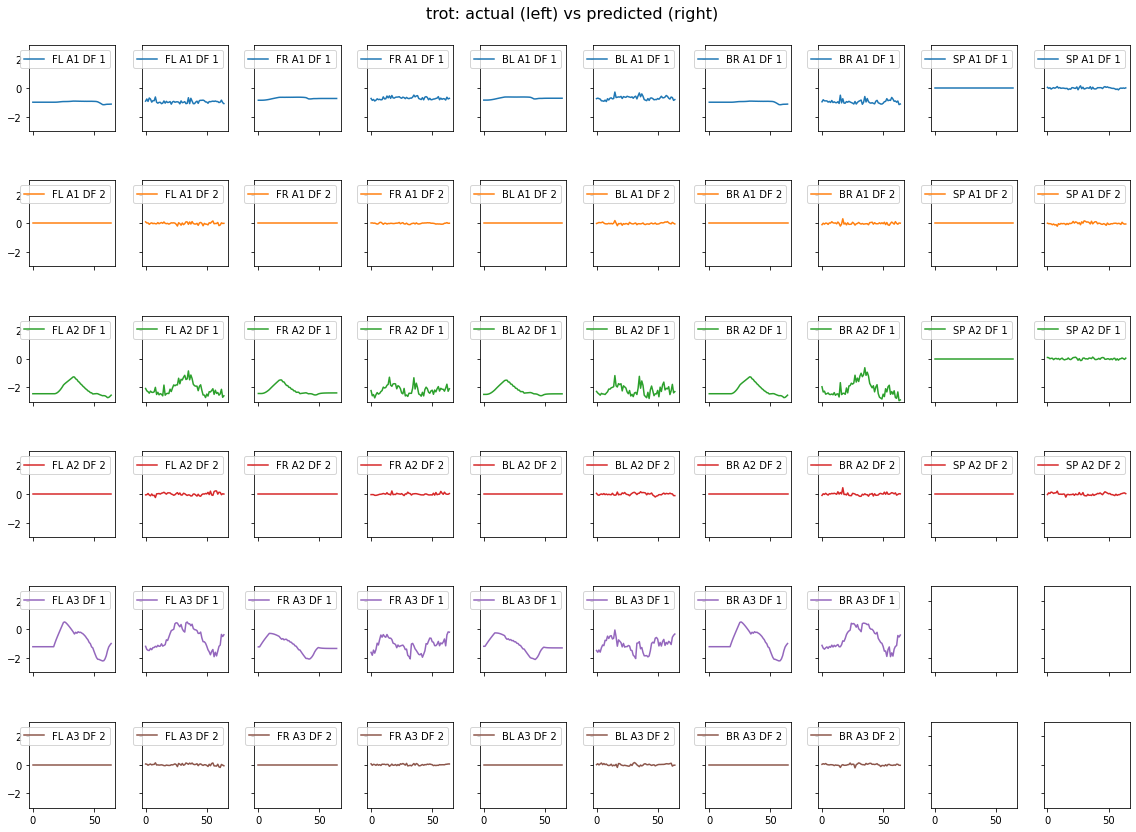

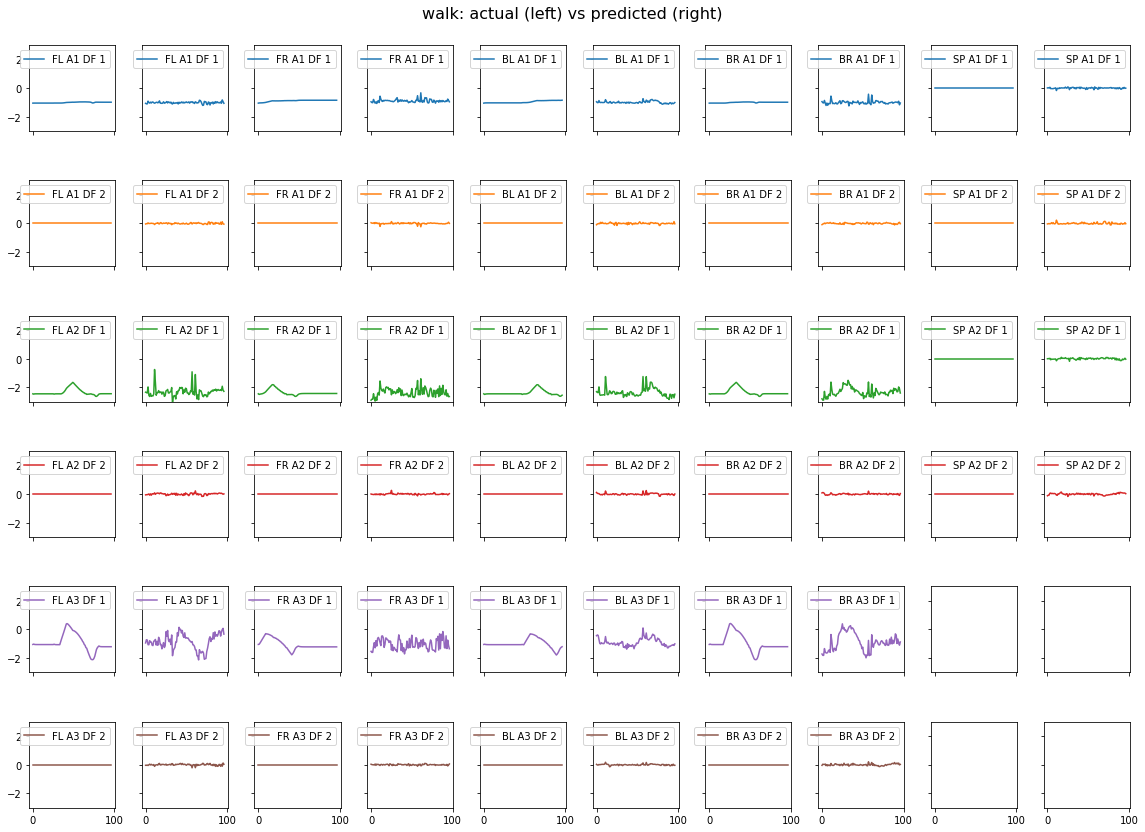

In [23]:
configs = [("bothoff", False, 0), ("onlydrop", False, 0.5), ("bothon", True, 0.5), ("onlybatch", True, 0)]

tmp_path = Path("TMP/")

names_and_ds = []

for filename in DATA_PATH.glob("*_kinematic.csv"):

    gait_name = filename.stem.split("_")[0]
    train_ds, test_ds = create_datasets(filename)
    names_and_ds.append((gait_name, train_ds, test_ds))

min_loss = inf
best_config = None

for config, batch, drop in configs:
    
    # trains all gait types w this config
    avg_loss = train_csv_plot(names_and_ds, tmp_path, tmp_path, plot=False, dropout=drop, batch_norm=batch, extra_id=config)

    if min_loss > avg_loss:
        min_loss = avg_loss
        best_config = config

    # now we've got a set of models trained w these specific configs and a csv for each. need to compare vs regular graphs
    config_outputs = sorted([x for x in tmp_path.glob(f"*_{config}.csv") if x.is_file()])

    plot_comparisons(data_files, config_outputs, tmp_path, extra_id=config) #plot to tmp folder

    




In [24]:
print(best_config)

bothoff


In [27]:
!jupytext --set-formats ipynb,py:percent gait_model.ipynb

[jupytext] Reading gait_model.ipynb in format ipynb
[jupytext] Updating notebook metadata with '{"jupytext": {"formats": "ipynb,py:percent"}}'
[jupytext] Updating gait_model.py
